# LecoSpec Image Segmentation

In [1]:
library(raster)
library(itcSegment)
library(rgdal)
library(sp)
library(sf)

Warning message:
"package 'raster' was built under R version 4.1.1"
Loading required package: sp

Warning message:
"package 'sp' was built under R version 4.1.1"
Loading required package: maptools

Warning message:
"package 'maptools' was built under R version 4.1.1"
Checking rgeos availability: TRUE
Please note that 'maptools' will be retired by the end of 2023,
plan transition at your earliest convenience;
some functionality will be moved to 'sp'.

Loading required package: rgeos

Warning message:
"package 'rgeos' was built under R version 4.1.1"
rgeos version: 0.5-7, (SVN revision 676)
 GEOS runtime version: 3.9.1-CAPI-1.14.2 
 Please note that rgeos will be retired by the end of 2023,
plan transition to sf functions using GEOS at your earliest convenience.
 GEOS using OverlayNG
 Linking to sp version: 1.4-5 
 Polygon checking: TRUE 


Warning message:
"package 'rgdal' was built under R version 4.1.1"
Please note that rgdal will be retired by the end of 2023,
plan transition to sf/s

In [2]:
source("./Scripts/Segmentation/crop_and_classify.R")

In [3]:
epsg_code <- 26983
target_wkt <- sf::st_crs(epsg_code)[[2]]
target_crs <- sp::CRS(target_wkt)

In [5]:
full_datacube_path <- "E:/Lecospec/raw_9105_rd_rf_or"
full_cube <- raster::brick(full_datacube_path)

In [6]:
segmentation_path <- "E:/Lecospec/hook_9105_crowndelins.shp"
manual_segmentation <- rgdal::readOGR(
    segmentation_path,
    verbose = TRUE)


OGR data source with driver: ESRI Shapefile 
Source: "E:\Lecospec\hook_9105_crowndelins.shp", layer: "hook_9105_crowndelins"
with 9 features
It has 1 fields


In [7]:
prediction_path <- "E:/Lecospec/raw_9105_rd_rf_or_PredLayer.tif"
prediction_raster <- raster::raster(prediction_path)

In [8]:
print("CRS and extent of Manual Segmentation")
print(crs(manual_segmentation))
print(extent(manual_segmentation))

print("CRS and extent of Full Datacube")
print(crs(full_cube))
print(extent(full_cube))

print("CRS and extent of Prediction")
print(crs(prediction_raster))
print(extent(prediction_raster))

[1] "CRS and extent of Manual Segmentation"
CRS arguments: +proj=longlat +datum=WGS84 +no_defs 
class      : Extent 
xmin       : -71.46068 
xmax       : -71.46004 
ymin       : 43.10938 
ymax       : 43.10958 
[1] "CRS and extent of Full Datacube"
CRS arguments: +proj=longlat +datum=WGS84 +no_defs 
class      : Extent 
xmin       : -71.46123 
xmax       : -71.45959 
ymin       : 43.10907 
ymax       : 43.10984 
[1] "CRS and extent of Prediction"
CRS arguments: +proj=longlat +datum=WGS84 +no_defs 
class      : Extent 
xmin       : -71.46123 
xmax       : -71.45959 
ymin       : 43.10907 
ymax       : 43.10984 


In [9]:
print("Cropping rasters to manual segmentation extent")
cropped_cube <- raster::mask(full_cube, manual_segmentation)
cropped_prediction <- raster::mask(prediction_raster, manual_segmentation)

[1] "Cropping rasters to manual segmentation extent"


In [14]:
print(paste0("Projecting rasters to EPSG ", epsg_code))
projected_cube <- raster::projectRaster(
    cropped_cube,
    crs = target_crs)
print("Cropped Datacube Projected")

projected_predictions <- raster::projectRaster(
    cropped_prediction,
    crs = target_crs,
    method = "ngb")
print("Cropped Prediction Projected")

print("Projecting Shapefile")
projected_shapes <- sp::spTransform(
    manual_segmentation,
    CRSobj = target_crs
    )
print("shapefiles projected")


[1] "Projecting rasters to EPSG 26983"
[1] "Cropped Datacube Projected"
[1] "Cropped Prediction Projected"
[1] "Projecting Shapefile"
[1] "shapefiles projected"


In [15]:
print("Saving cropped DataCubes")

cropped_cube_path <- "E:/Lecospec/cropped_hooksett_datacube_26983.tif"
raster::writeRaster(projected_cube, cropped_cube_path)

cropped_prediction_path <- "E:/Lecospec/cropped_prediction_26983.tif"
raster::writeRaster(projected_predictions, cropped_prediction_path)

[1] "Saving cropped DataCubes"


ERROR: Error in .getGDALtransient(x, filename = filename, options = options, : filename exists; use overwrite=TRUE


In [12]:
dist <- 40
window <- 41
thresh_base <- 0.6
delta_t <- 0.15

# Perform segmentation
automated_segmentation <- itcSegment::itcIMG(
    imagery = as(projected_cube[[225]], "RasterLayer"),
    epsg = 26983,
    TRESHSeed = thresh_base,
    TRESHCrown = (thresh_base + delta_t),
    searchWinSize = window,
    DIST = dist
)

print(automated_segmentation)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'focal': object 'projected_cube' not found


In [ ]:
print(automated_segmentation)

class       : SpatialPolygonsDataFrame 
features    : 85 
extent      : 59029.42, 59081.32, -57653.66, -57630.3  (xmin, xmax, ymin, ymax)
crs         : +proj=tmerc +lat_0=43.6666666666667 +lon_0=-68.5 +k=0.9999 +x_0=300000 +y_0=0 +datum=NAD83 +units=m +no_defs 
variables   : 3
names       :        X,         Y, CA_m2 
min values  : 59031.27, -57652.58,  1.33 
max values  : 59080.26, -57631.43, 19.25 


In [ ]:
savepath <- "./nhti_automated_segmentation.shp"
print(automated_segmentation)
rgdal::writeOGR(
    automated_segmentation,
    ".",
    savepath,
    driver = "ESRI Shapefile")

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'print': object 'automated_segmentation' not found


## Extractor Test

In [ ]:
print("Filtering Segmentation")
filtered_segmentation <- filter_segmentation(
    projected_shapes,
    automated_segmentation)

[1] "Filtering Segmentation"


In [ ]:
print("Extracting Spectral from datacube based on automated segmentation")
auto_spectra_path <- "./automatically_extracted_spectra.csv"
pixel_spectra_auto <- extract_spectra(
    projected_cube,
    automated_segmentation)
summary(pixel_spectra_auto)
write.csv(pixel_spectra_auto, auto_spectra_path)



[1] "Extracting Spectral from datacube based on automated segmentation"
[1] "Cropping Raster to Polygon 1"
[1] "Cropping Raster to Polygon 2"
[1] "Cropping Raster to Polygon 3"
[1] "Cropping Raster to Polygon 4"
[1] "Cropping Raster to Polygon 5"
[1] "Cropping Raster to Polygon 6"
[1] "Cropping Raster to Polygon 7"
[1] "Cropping Raster to Polygon 8"
[1] "Cropping Raster to Polygon 9"
[1] "Cropping Raster to Polygon 10"
[1] "Cropping Raster to Polygon 11"
[1] "Cropping Raster to Polygon 12"
[1] "Cropping Raster to Polygon 13"
[1] "Cropping Raster to Polygon 14"
[1] "Cropping Raster to Polygon 15"
[1] "Cropping Raster to Polygon 16"
[1] "Cropping Raster to Polygon 17"
[1] "Cropping Raster to Polygon 18"
[1] "Cropping Raster to Polygon 19"
[1] "Cropping Raster to Polygon 20"
[1] "Cropping Raster to Polygon 21"
[1] "Cropping Raster to Polygon 22"
[1] "Cropping Raster to Polygon 23"
[1] "Cropping Raster to Polygon 24"
[1] "Cropping Raster to Polygon 25"
[1] "Cropping Raster to Polygon 26"
[

       x               y           X397.593.nm        X399.444.nm      
 Min.   :59029   Min.   :-57654   Min.   :-0.02672   Min.   :-0.03710  
 1st Qu.:59045   1st Qu.:-57647   1st Qu.: 0.01088   1st Qu.: 0.01125  
 Median :59057   Median :-57642   Median : 0.01971   Median : 0.01882  
 Mean   :59056   Mean   :-57642   Mean   : 0.02180   Mean   : 0.02032  
 3rd Qu.:59068   3rd Qu.:-57637   3rd Qu.: 0.03023   3rd Qu.: 0.02750  
 Max.   :59081   Max.   :-57630   Max.   : 0.12857   Max.   : 0.11321  
  X401.296.nm        X403.148.nm          X405.nm          X406.851.nm      
 Min.   :-0.01886   Min.   :-0.01889   Min.   :-0.01132   Min.   :-0.01196  
 1st Qu.: 0.01167   1st Qu.: 0.01304   1st Qu.: 0.01337   1st Qu.: 0.01386  
 Median : 0.01816   Median : 0.01921   Median : 0.01915   Median : 0.01963  
 Mean   : 0.01924   Mean   : 0.02021   Mean   : 0.01996   Mean   : 0.02031  
 3rd Qu.: 0.02535   3rd Qu.: 0.02621   3rd Qu.: 0.02569   3rd Qu.: 0.02604  
 Max.   : 0.08708   Max.   : 0.091

[1] "Extracting Spectral from datacube based on manual segmentation"
[1] "Cropping Raster to Polygon 1"


ERROR: Error in .local(x, y, ...): extents do not overlap


## Assigner Test

In [11]:
print("Extracting Spectra from datacube based on manual segmentation")
man_spectra_path <- "./manually_extracted_spectra.csv"
pixel_spectra_man <- extract_spectra(
    cropped_cube,
    manual_segmentation)
summary(pixel_spectra_man)
write.csv(pixel_spectra_man, man_spectra_path) 

[1] "Extracting Spectra from datacube based on manual segmentation"
[1] "Cropping Raster to Polygon 1"
[1] "Cropping Raster to Polygon 2"
[1] "Cropping Raster to Polygon 3"


Warning message in writeBin(as.vector(v[start:end, ]), x@file@con, size = x@file@dsize):
"problem writing to connection"
Warning message in writeBin(as.vector(v[start:end, ]), x@file@con, size = x@file@dsize):
"problem writing to connection"
Warning message in writeBin(as.vector(v[start:end, ]), x@file@con, size = x@file@dsize):
"problem writing to connection"
Warning message in writeBin(as.vector(v[start:end, ]), x@file@con, size = x@file@dsize):
"problem writing to connection"
Warning message in writeBin(as.vector(v[start:end, ]), x@file@con, size = x@file@dsize):
"problem writing to connection"
Warning message in writeBin(as.vector(v[start:end, ]), x@file@con, size = x@file@dsize):
"problem writing to connection"
Warning message in writeBin(as.vector(v[start:end, ]), x@file@con, size = x@file@dsize):
"problem writing to connection"
Warning message in writeBin(as.vector(v[start:end, ]), x@file@con, size = x@file@dsize):
"problem writing to connection"
Warning message in writeBin(as.v

[1] "Cropping Raster to Polygon 4"


Warning message in writeBin(as.vector(v[start:end, ]), x@file@con, size = x@file@dsize):
"problem writing to connection"
Warning message in writeBin(as.vector(v[start:end, ]), x@file@con, size = x@file@dsize):
"problem writing to connection"
Warning message in writeBin(as.vector(v[start:end, ]), x@file@con, size = x@file@dsize):
"problem writing to connection"
Warning message in writeBin(as.vector(v[start:end, ]), x@file@con, size = x@file@dsize):
"problem writing to connection"
Warning message in writeBin(as.vector(v[start:end, ]), x@file@con, size = x@file@dsize):
"problem writing to connection"
Warning message in writeBin(as.vector(v[start:end, ]), x@file@con, size = x@file@dsize):
"problem writing to connection"
Warning message in writeBin(as.vector(v[start:end, ]), x@file@con, size = x@file@dsize):
"problem writing to connection"
Warning message in writeBin(as.vector(v[start:end, ]), x@file@con, size = x@file@dsize):
"problem writing to connection"
Warning message in writeBin(as.v

[1] "Cropping Raster to Polygon 5"


Warning message in writeBin(as.vector(v[start:end, ]), x@file@con, size = x@file@dsize):
"problem writing to connection"
Warning message in writeBin(as.vector(v[start:end, ]), x@file@con, size = x@file@dsize):
"problem writing to connection"
Warning message in writeBin(as.vector(v[start:end, ]), x@file@con, size = x@file@dsize):
"problem writing to connection"
Warning message in writeBin(as.vector(v[start:end, ]), x@file@con, size = x@file@dsize):
"problem writing to connection"
Warning message in writeBin(as.vector(v[start:end, ]), x@file@con, size = x@file@dsize):
"problem writing to connection"
Warning message in writeBin(as.vector(v[start:end, ]), x@file@con, size = x@file@dsize):
"problem writing to connection"
Warning message in writeBin(as.vector(v[start:end, ]), x@file@con, size = x@file@dsize):
"problem writing to connection"
Warning message in writeBin(as.vector(v[start:end, ]), x@file@con, size = x@file@dsize):
"problem writing to connection"
Warning message in writeBin(as.v

In [13]:
cropped_shapes <- crop_raster_to_shapes(
    projected_predictions,
    projected_shapes)
assigned_rasters <- lapply(
    cropped_shapes,
    assign_target_to_segment)
print(assigned_rasters)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'nrow': object 'projected_shapes' not found


In [ ]:
merged_segments <- merge_raster_list(assigned_rasters)

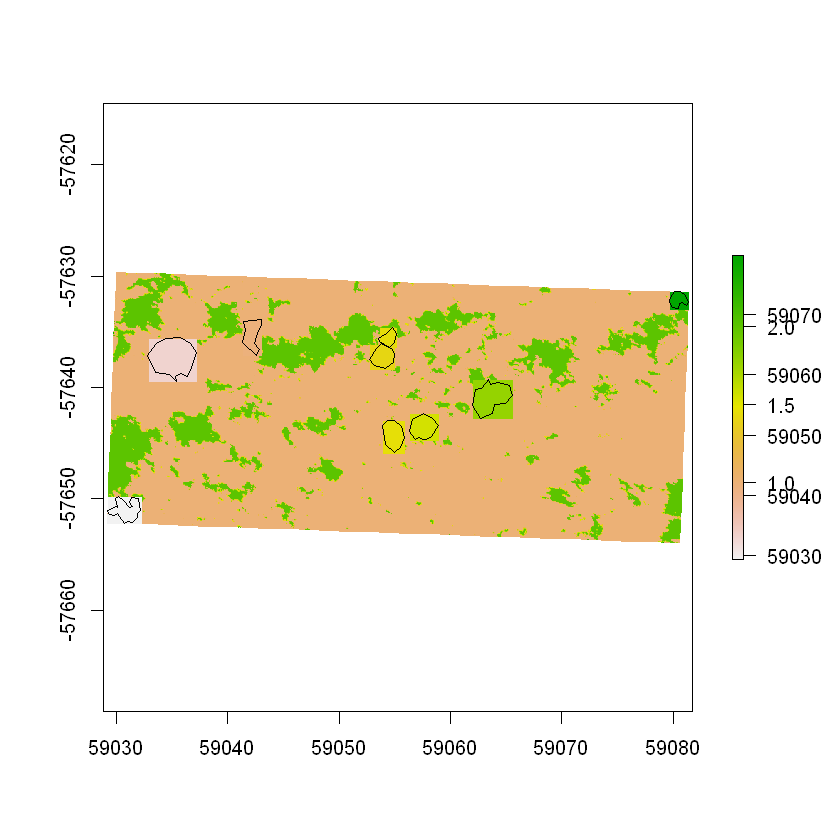

In [ ]:
plot(projected_predictions)
plot(merged_segments, add = TRUE)
plot(projected_shapes, add = TRUE)

### Segmentation
There are three cubes with digitized crowns.  
